In [20]:
SOURCE = "sparsity_pickles_4"

In [21]:
import pickle
with open("{}/sparsity.pickle".format(SOURCE), "rb") as input_file:
    raw = pickle.loads(input_file.read())

In [22]:
import matplotlib.pyplot as plt
import numpy as np

In [23]:
def accuracy(confusion_matrix):
    return (confusion_matrix[0][0] + confusion_matrix[1][1]) / np.sum(confusion_matrix)

def specificity(confusion_matrix):
    return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])

def sensitivity(confusion_matrix):
    return confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])

## Hard-Cutoff

Since implementing hard-cutoff in the main training script is difficult due to dynamic configurations, a static implementation is provided here

New data is created; this new data augments the original file and is saved in a new location

In [24]:
with open("data/testing-rapid.pickle", "rb") as input_file:
    testing_data = pickle.loads(input_file.read())
    testing_in, testing_out = testing_data["in"], testing_data["out"]
    
with open("data/validation-rapid.pickle", "rb") as input_file:
    validation_data = pickle.loads(input_file.read())
    validation_in, validation_out = validation_data["in"], validation_data["out"]

In [25]:
def evaluateTestingData(params, data):
    
    data_in, data_out = data
    
    def sigmoid(x):
        return (x > 0).astype("float")

    layer1 = sigmoid(np.dot(data_in, np.multiply(params[0][0], params[0][2])) + params[0][1])
    layer2 = np.dot(layer1, params[1][0]) + params[1][1]
    
    predicted_encodings = np.array([np.where(r == np.max(r))[0][0] for r in layer2])
    actual_encodings = np.array([np.where(r == np.max(r))[0][0] for r in data_out])
    
    matrix = np.zeros((testing_out.shape[1], testing_out.shape[1]))
    for predicted_int, actual_int in zip(predicted_encodings, actual_encodings):
        matrix[actual_int][predicted_int] += 1
        
    return matrix

In [26]:
for i, cycle in enumerate(raw["results"]):
    print("Cycle {}...".format(i))
    cycle["final_eval"]["testing_confusion_cutoff"] = evaluateTestingData(
            cycle["final_params"], (testing_in, testing_out))
    cycle["final_eval"]["validation_confusion_cutoff"] = evaluateTestingData(
            cycle["final_params"], (validation_in, validation_out))
    for stage in cycle["steepening"]:
        stage["final_eval"]["testing_confusion_cutoff"] = evaluateTestingData(
                stage["final_params"], (testing_in, testing_out))
        stage["final_eval"]["validation_confusion_cutoff"] = evaluateTestingData(
                stage["final_params"], (validation_in, validation_out))

Cycle 0...
Cycle 1...
Cycle 2...
Cycle 3...
Cycle 4...
Cycle 5...
Cycle 6...
Cycle 7...
Cycle 8...
Cycle 9...
Cycle 10...
Cycle 11...
Cycle 12...
Cycle 13...
Cycle 14...
Cycle 15...
Cycle 16...
Cycle 17...
Cycle 18...
Cycle 19...
Cycle 20...
Cycle 21...
Cycle 22...
Cycle 23...
Cycle 24...
Cycle 25...
Cycle 26...
Cycle 27...
Cycle 28...
Cycle 29...


In [27]:
with open("{}/sparsity-augmented.pickle".format(SOURCE), "wb") as output_file:
    pickle.dump(raw, output_file)

## Accuracy vs. Sparsity

The accuracy of the validation data was not affected as sparsity of the first set of weights of the neural network approached 90%

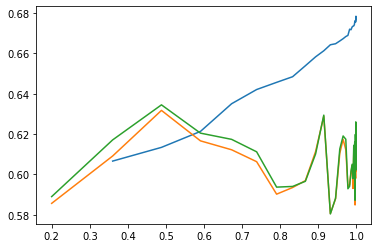

In [28]:
sparsities = [cycle["final_sparsity"][0] for cycle in raw["results"]]
val_accuracy = [cycle["final_eval"]["validation_eval"][1] for cycle in raw["results"]]
test_accuracy = [cycle["final_eval"]["testing_eval"][1] for cycle in raw["results"]]
training_accuracy = [cycle["training_history"]["accuracy"][0] for cycle in raw["results"]]
plt.plot(sparsities[1:], training_accuracy[1:])
plt.plot(sparsities, val_accuracy)
plt.plot(sparsities, test_accuracy)

## Accuracy vs. Steepening

Given a fixed amount of sparsity in the network, this shows how the accuracy of the training and validation data changes as the model's activation curve is steepened

Each red dot marks the point at which the activation curve is steepened

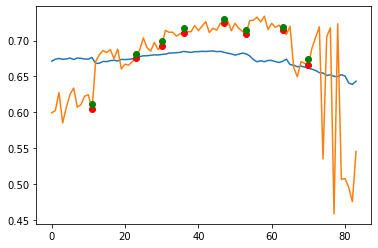

In [29]:
cycle = raw["results"][-10]

metrics_2d = cycle["steepening"]
metrics_1d = {}
for stage in metrics_2d:
    for key, items in stage["training_history"].items():
        augmented = metrics_1d.get(key, []) + items
        metrics_1d[key] = augmented
        
epochs_per_stage = []
counter = 0
for stage in metrics_2d:
    counter += len(stage["training_history"]["loss"])
    epochs_per_stage.append(counter)

plt.plot(metrics_1d["accuracy"])
plt.plot(metrics_1d["val_accuracy"])
plt.plot([i-1 for i in epochs_per_stage[:-1]],
         [accuracy(stage["final_eval"]["validation_confusion"]) for stage in cycle["steepening"][:-1]], "ro")
plt.plot([i-1 for i in epochs_per_stage[:-1]],
         [accuracy(stage["final_eval"]["testing_confusion"]) for stage in cycle["steepening"][:-1]], "go")

## Diagnostic Utility with Hard-Cutoff

For each steepness and sparsity, the associated parameters are used in a network structure with the hard-cutoff activation function to generate a confusion matrix with the testing data. Confusion matrices offer insight on the diagnostic capacity of the model.

### Note on Confusion Matrices

Confusion matrices for the "rapid" output categorization have the following configuration:

 * **Positive**: the patient is readmitted within 30 days
 * **Negative**: the patient is readmitted after 30 days or not readmitted at all
 
|                 | Predicted Positive | Predicted Negative |   |   |
|-----------------|--------------------|--------------------|---|---|
| Actual Positive |  True Positive     | False Negative     |   |   |
| Actual Negative | False Positive     | True Negative      |   |   |
|                 |                    |                    |   |   |

These [definitions](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) are used to calculate statistics (like accuracy).

This is a [useful resource](https://www.graphpad.com/guides/prism/7/statistics/index.htm?stat_interpreting_results_contingen_2.htm) for interpreting sensitivity and specificity.

The **likelihood ratio** is how much more likely the true value is positive given that the test is positive than the given that the test is negative. It is calculated as $$\frac{\mathrm{sensitivity}}{1 - \mathrm{specificity}}$$

In [30]:
def metrics(sequence):
    _accuracy = np.array([accuracy(cycle["final_eval"]["testing_confusion_cutoff"]) for cycle in sequence])
    _specificity = np.array([specificity(cycle["final_eval"]["testing_confusion_cutoff"]) for cycle in sequence])
    _sensitivity = np.array([sensitivity(cycle["final_eval"]["testing_confusion_cutoff"]) for cycle in sequence])
    
    return _accuracy, _specificity, _sensitivity

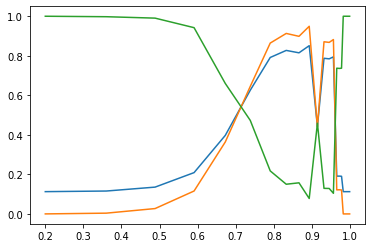

In [31]:
sparsification_metrics = metrics(raw["results"])

for metric in sparsification_metrics:
    plt.plot(sparsities, metric)

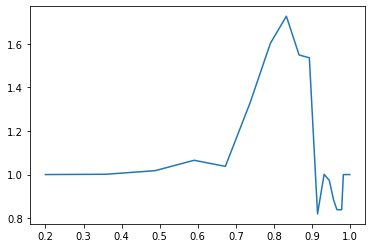

In [32]:
plt.plot(sparsities, sparsification_metrics[2] / (1 - sparsification_metrics[1]))

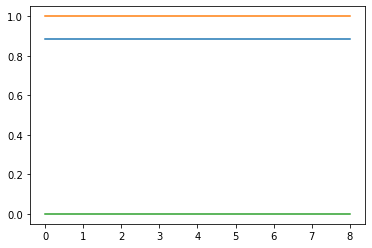

In [33]:
steepening_metrics = metrics(raw["results"][-2]["steepening"])

for metric in steepening_metrics:
    plt.plot(metric)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


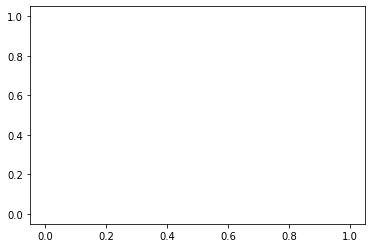

In [34]:
plt.plot(steepening_metrics[2] / (1 - steepening_metrics[1]))

In [35]:
aggregate = [[cycle] + cycle["steepening"] for cycle in raw["results"]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


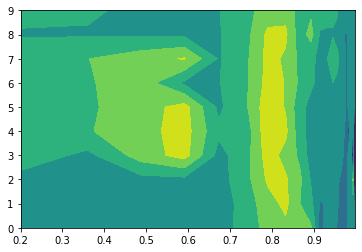

In [36]:
aggregate_confusion = [[stage["final_eval"]["testing_confusion_cutoff"] for stage in cycle] for cycle in aggregate]
aggregate_likelihood = np.array([[sensitivity(c) / (1 - specificity(c)) for c in cycle] for cycle in aggregate_confusion])
aggregate_likelihood = np.nan_to_num(aggregate_likelihood, 0)

aggregate_sparsity = np.array([[cycle[0]["final_sparsity"][0]] * len(cycle) for cycle in aggregate])
aggregate_steepness = np.array([[i for i in range(aggregate_likelihood.shape[1])] for j in range(aggregate_likelihood.shape[0])])

plt.contourf(aggregate_sparsity, aggregate_steepness, aggregate_likelihood)

In [37]:
max_index = np.argmax(aggregate_likelihood)
max_coords = (max_index // aggregate_likelihood.shape[1], max_index % aggregate_likelihood.shape[1])
aggregate_likelihood[max_coords]

2.020567831056509

## Network Complexity

In [41]:
avg_performance = []
max_performance = []
network_emptiness_l1 = []
#network_emptiness_l2 = []
network_n_weights = []

for cycle_i in range(len(aggregate)):
    W1 = aggregate[cycle_i][0]["final_params"][0][2]
    #W2 = aggregate[cycle_i][0]["final_params"][1][2]
    
    network_n_weights.append(np.sum(W1))
    
    n_zero_cols_l1 = len(np.where(np.sum(W1, axis=1) == 0)[0])
    #n_zero_cols_l2 = len(np.where(np.sum(W2, axis=1) == 0)[0])
    network_emptiness_l1.append(n_zero_cols_l1)
    #network_emptiness_l2.append(n_zero_cols_l2)
    
    _avg_performance = sum(aggregate_likelihood[cycle_i]) / len(aggregate[cycle_i])
    _max_performance = max(aggregate_likelihood[cycle_i])
    avg_performance.append(_avg_performance)
    max_performance.append(_max_performance)

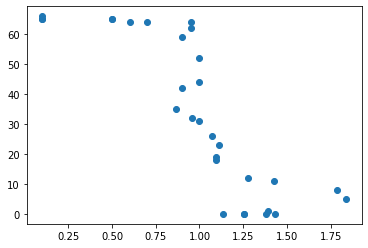

In [42]:
plt.plot(avg_performance, network_emptiness_l1, "o")
#plt.plot(avg_performance, network_emptiness_l2, "o")

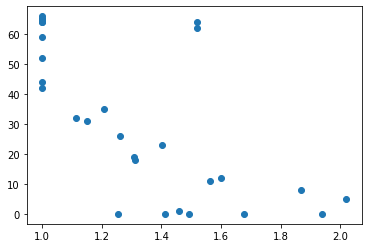

In [43]:
plt.plot(max_performance, network_emptiness_l1, "o")
#plt.plot(max_performance, network_emptiness_l2, "o")

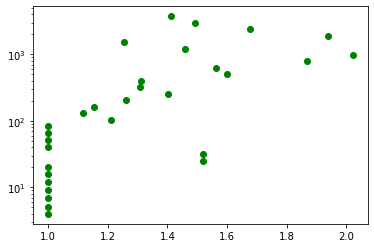

In [44]:
plt.plot(max_performance, network_n_weights, "go")
plt.yscale("log")